In [62]:
import yaml
import json
from pathlib import Path
import pandas as pd
import torch

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/f_mnist/logs/fixed_decomp")

In [63]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 60


In [64]:
from datetime import datetime

dts = [datetime.fromtimestamp(int(x)) for x in folders]
print(max(dts))
print(min(dts))

2022-02-21 16:28:24
2022-02-21 11:37:56


In [65]:
paths = []
for folder in folders:
    found_decomp = False
    found_results = False
    for subfolder in os.listdir(logdir / folder):
        if 'lr' in subfolder:
            # found_decomp = True
            # break
            if (logdir / folder / subfolder / "results.json").exists():
                paths.append( logdir / folder / subfolder )
    # if not found_decomp or not found_results:
    #     folders.remove(folder)
print(len(paths))

60


In [66]:
# baseline

baseline_path = Path("/bigdata/f_mnist/logs/baselines/1644945876/rn18_18_dNone_256_adam_l0.001_g0.1_sTrue/cnn_best.pth")
baseline_model = torch.load(baseline_path)

In [67]:
def paths_to_results(paths):
    """Returns a pandas DataFrame with results"""
    results = []
    for path in paths:
        with open(path/'results.json') as json_file:
            result = json.load(json_file)
        results.append(result)
    
    keys = set()
    for result in results:
        keys = keys.union( set(result.keys()) )
    
    blank = {k:[] for k in keys}
    
    df = pd.DataFrame(blank) #.append(results[1], ignore_index=True)

    for result in results:
        df = df.append(result, ignore_index=True)
        
    df['compression'] = df['n_param_fact']/df['n_param'][0]
    df.compression[0] = 1.0
    
    
    return df

In [68]:
import torch
import tensorly as tl
tl.set_backend('pytorch')
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

In [69]:
# calc approximation error
# store in approx_error.json, next to results.json
import yaml

for path in paths:
    # print(path)
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    layers = config_data['layers']

    fact_model = torch.load(path / 'model_after_fact.pth')

    pretrained_numbered_layers = number_layers(baseline_model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers,
        layer_nrs=layers,
    )

    decomposed_numbered_layers = number_layers(fact_model)
    decomposed_conv_layers = listify_numbered_layers(
        decomposed_numbered_layers,
        layer_nrs=layers,
    )

    with open(path / 'results.json') as json_file:
        result = json.load(json_file)

    with open(path / 'results_before_training.json') as json_file:
        result_before_training = json.load(json_file)

    errors_conv = {
            'name': [],
            'nr': [],
            'error': [],
            'layers': layers,
            'factorization': config_data['factorization'],
            'rank': config_data['rank'],
            'valid_acc': result['best_valid_acc'],
            'valid_acc_before_ft': result_before_training['valid_acc'],
            'n_param_fact': result['n_param_fact'],
            'test_acc': result['test_acc'],
            'lr': config_data['lr'],
            'optimizer': config_data['optimizer'],
        }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        # print(name)
        nr = pre[1]
        # print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        # print(error)
        
        errors_conv['name'].append(name)
        errors_conv['nr'].append(nr)
        errors_conv['error'].append(float(error))

    errors_path = logdir / path / 'results_approximation_error.json'
    with open(errors_path, 'w') as f:
        json.dump(errors_conv, f)

In [70]:
results = []
for path in paths:
    with open(path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results.append(result)

{'name': ['conv1'], 'nr': [44], 'error': [0.3200853765010834], 'layers': [44], 'factorization': 'cp', 'rank': 0.5, 'valid_acc': 0.9566, 'valid_acc_before_ft': 0.9566, 'n_param_fact': 10878297, 'test_acc': 0.9439, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv1'], 'nr': [19], 'error': [0.3224080502986908], 'layers': [19], 'factorization': 'cp', 'rank': 0.5, 'valid_acc': 0.9554, 'valid_acc_before_ft': 0.9556, 'n_param_fact': 11136096, 'test_acc': 0.9446, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv2'], 'nr': [15], 'error': [0.3485225737094879], 'layers': [15], 'factorization': 'cp', 'rank': 0.5, 'valid_acc': 0.9562, 'valid_acc_before_ft': 0.9548, 'n_param_fact': 11154576, 'test_acc': 0.9452, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv2'], 'nr': [15], 'error': [0.3485225737094879], 'layers': [15], 'factorization': 'cp', 'rank': 0.5, 'valid_acc': 0.9562, 'valid_acc_before_ft': 0.9548, 'n_param_fact': 11154576, 'test_acc': 0.9455, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['c

In [71]:
df = pd.DataFrame(results)
df.head()


,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer
0,conv1,44,0.320085,44,cp,0.5,0.9566,0.9566,10878297,0.9439,0.00001,adam
1,conv1,19,0.322408,19,cp,0.5,0.9554,0.9556,11136096,0.9446,0.00001,adam
2,conv2,15,0.348523,15,cp,0.5,0.9562,0.9548,11154576,0.9452,0.00001,adam
3,conv2,15,0.348523,15,cp,0.5,0.9562,0.9548,11154576,0.9455,0.00001,adam
4,conv1,44,0.320085,44,cp,0.5,0.9568,0.9566,10878297,0.9452,0.00001,adam


In [72]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
# df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layer_rank'] = df['layers'].apply(str) + '-' + df['rank'].apply(str)

In [12]:
df_rank = df.set_index('rank', inplace=False)

factorization
cp    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

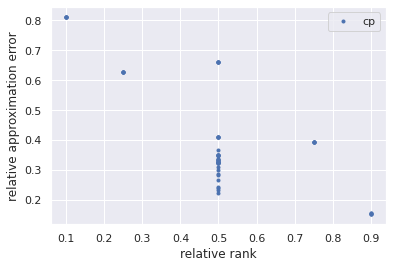

In [13]:
grouped_df = df_rank.groupby('factorization')
grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error', xlabel='relative rank')

fact_layers
cp-15    AxesSubplot(0.125,0.125;0.775x0.755)
cp-19    AxesSubplot(0.125,0.125;0.775x0.755)
cp-28    AxesSubplot(0.125,0.125;0.775x0.755)
cp-38    AxesSubplot(0.125,0.125;0.775x0.755)
cp-41    AxesSubplot(0.125,0.125;0.775x0.755)
cp-44    AxesSubplot(0.125,0.125;0.775x0.755)
cp-60    AxesSubplot(0.125,0.125;0.775x0.755)
cp-63    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

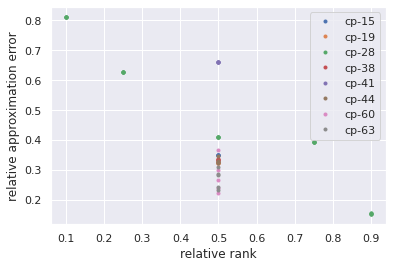

In [16]:
fact_layers_df = df_rank.groupby('fact_layers')
fact_layers_df['error'].plot(legend=True, style=".", ylabel='relative approximation error', xlabel='relative rank')

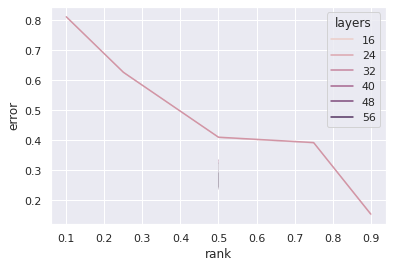

In [18]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="layers",
    # style="rank",
    data=df,
    # palette=['orange', 'b'],
)

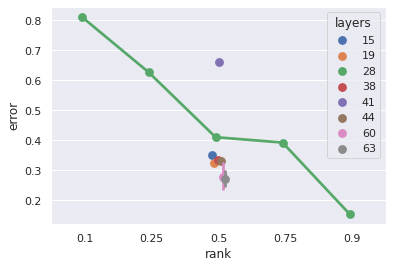

In [24]:
ax = sns.pointplot(x="rank", y="error",
    hue="layers",
    # style="rank",
    data=df,
    # palette=['orange', 'b'],
    dodge=True,
)

In [125]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [31]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

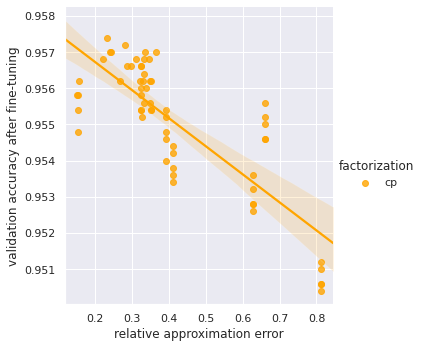

In [26]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g = g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

In [26]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank
0,conv2,38,0.417443,38,tucker,0.50,0.9566,0.9560,10878589,0.9445,0.00001,adam,tucker-0.5
1,conv1,44,0.322214,44,cp,0.50,0.9566,0.9566,10878297,0.9448,0.00001,adam,cp-0.5
2,conv1,28,0.538981,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam,tucker-0.5
3,conv1,28,0.392504,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam,tucker-0.75
4,conv2,15,0.508425,15,tucker,0.50,0.9538,0.9532,11154645,0.9453,0.00001,adam,tucker-0.5


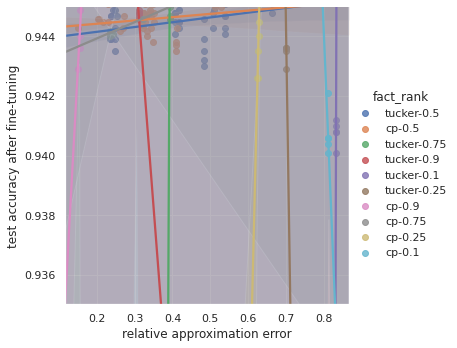

In [27]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="fact_rank", 
   data=df,
   truncate=False, 
   # palette=['orange','b'],
)
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
g.set(ylim=(0.935, 0.945))

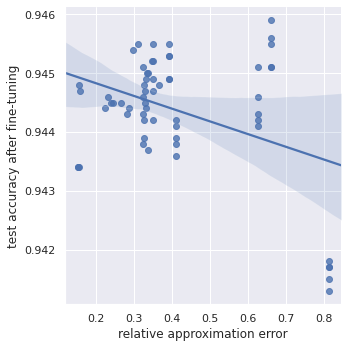

In [37]:
g = sns.lmplot(x="error", y="test_acc", 
   # hue="layers", 
   data=df,
   # logistic=True,
   truncate=False, 
   # palette=['orange','b'],
)
g = g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
# g = g.set(ylim=(0.940, 0.945))

In [38]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

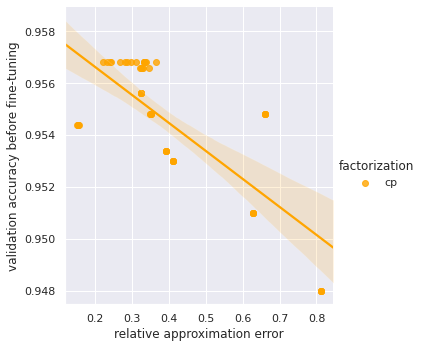

In [39]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [40]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer
0,conv1,44,0.325148,44,cp,0.5,0.9566,0.9566,10878297,0.9439,0.00001,adam
1,conv1,19,0.323476,19,cp,0.5,0.9554,0.9556,11136096,0.9446,0.00001,adam
2,conv2,15,0.349345,15,cp,0.5,0.9562,0.9548,11154576,0.9452,0.00001,adam
3,conv2,15,0.350393,15,cp,0.5,0.9562,0.9548,11154576,0.9455,0.00001,adam
4,conv1,44,0.347077,44,cp,0.5,0.9568,0.9566,10878297,0.9452,0.00001,adam
5,conv1,44,0.329837,44,cp,0.5,0.9562,0.9566,10878297,0.9445,0.00001,adam
10,conv1,19,0.324213,19,cp,0.5,0.9560,0.9556,11136096,0.9438,0.00001,adam
12,0,41,0.661829,41,cp,0.5,0.9550,0.9548,11156556,0.9456,0.00001,adam
13,conv2,38,0.337684,38,cp,0.5,0.9560,0.9568,10878297,0.9450,0.00001,adam
14,conv2,63,0.244079,63,cp,0.5,0.9570,0.9568,9994009,0.9445,0.00001,adam


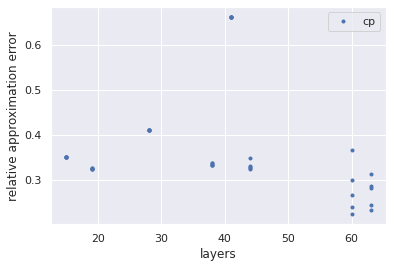

In [41]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [42]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [44]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

<AxesSubplot:xlabel='layers', ylabel='error'>

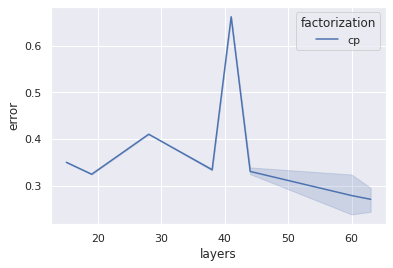

In [46]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
            #  palette=['orange', 'b'],
             )

<AxesSubplot:xlabel='layers', ylabel='error'>

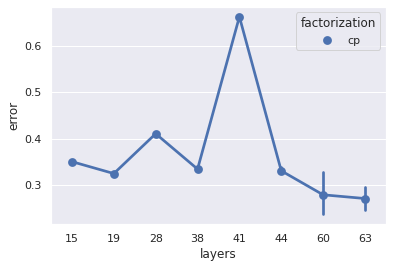

In [48]:
sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
            #  palette=['orange', 'b'],
             dodge=True
             )

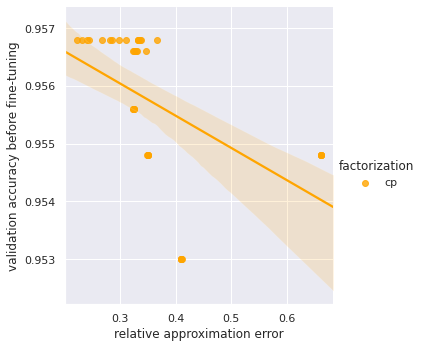

In [49]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

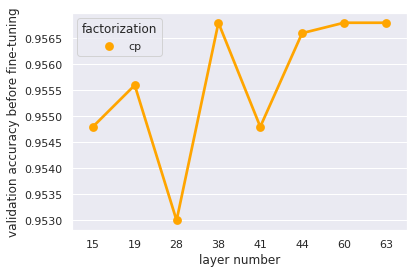

In [50]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax = ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')

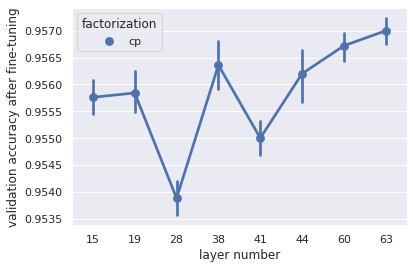

In [77]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    # palette=['orange', 'b'],
    dodge=True,
    )
ax = ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')

[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

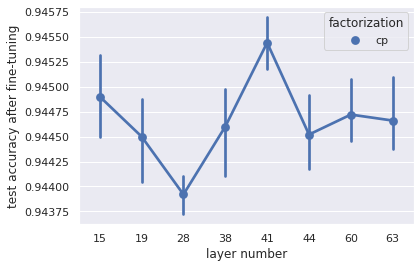

In [76]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
            #  palette=['orange', 'b'],
             dodge=True)
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [54]:
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank,fact_layers,layer_rank
0,conv1,44,0.325148,44,cp,0.5,0.9566,0.9566,10878297,0.9439,0.00001,adam,cp-0.5,cp-44,44-0.5
1,conv1,19,0.323476,19,cp,0.5,0.9554,0.9556,11136096,0.9446,0.00001,adam,cp-0.5,cp-19,19-0.5
2,conv2,15,0.349345,15,cp,0.5,0.9562,0.9548,11154576,0.9452,0.00001,adam,cp-0.5,cp-15,15-0.5
3,conv2,15,0.350393,15,cp,0.5,0.9562,0.9548,11154576,0.9455,0.00001,adam,cp-0.5,cp-15,15-0.5
4,conv1,44,0.347077,44,cp,0.5,0.9568,0.9566,10878297,0.9452,0.00001,adam,cp-0.5,cp-44,44-0.5


In [94]:
df_layer_rank = df.groupby(['factorization','layers','rank'])

In [95]:
print(df_layer_rank[['valid_acc','test_acc']].std().to_latex())

\begin{tabular}{lllrr}
\toprule
   &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 15 & 0.50 &   0.000410 &  0.000495 \\
   & 19 & 0.50 &   0.000498 &  0.000510 \\
   & 28 & 0.10 &   0.000329 &  0.000200 \\
   &    & 0.25 &   0.000400 &  0.000404 \\
   &    & 0.50 &   0.000415 &  0.000239 \\
   &    & 0.75 &   0.000548 &  0.000268 \\
   &    & 0.90 &   0.000529 &  0.000740 \\
   & 38 & 0.50 &   0.000573 &  0.000561 \\
   & 41 & 0.50 &   0.000424 &  0.000344 \\
   & 44 & 0.50 &   0.000616 &  0.000482 \\
   & 60 & 0.50 &   0.000335 &  0.000409 \\
   & 63 & 0.50 &   0.000316 &  0.000483 \\
\bottomrule
\end{tabular}



In [97]:
df_adam = pd.read_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")
df_adam_grouped = df_adam.groupby(['factorization','layers','rank'])

In [90]:
df_copy = df.copy()
df_copy[['error','valid_acc','valid_acc_before_ft','test_acc']] = df_adam[['error','valid_acc','valid_acc_before_ft','test_acc']] - df[['error','valid_acc','valid_acc_before_ft','test_acc']]
df_layer_rank_copy = df_copy.groupby(['layers','rank'])


In [91]:
df_layer_rank_copy

In [92]:
print(df_layer_rank_copy[['valid_acc','test_acc']].std().to_latex())

\begin{tabular}{llrr}
\toprule
   &      &  valid\_acc &  test\_acc \\
layers & rank &            &           \\
\midrule
15 & 0.50 &   0.002215 &  0.000505 \\
19 & 0.50 &   0.003297 &  0.001420 \\
28 & 0.10 &   0.001081 &  0.000286 \\
   & 0.25 &   0.000438 &  0.000650 \\
   & 0.50 &   0.003051 &  0.001703 \\
   & 0.75 &   0.001404 &  0.000495 \\
   & 0.90 &   0.003439 &  0.001524 \\
38 & 0.50 &   0.001800 &  0.000444 \\
41 & 0.50 &   0.002956 &  0.001981 \\
44 & 0.50 &   0.001715 &  0.001811 \\
60 & 0.50 &   0.002043 &  0.000467 \\
63 & 0.50 &   0.001299 &  0.000780 \\
\bottomrule
\end{tabular}



In [103]:
df_grouped_diff = df_adam_grouped[['valid_acc','test_acc']].std() - df_layer_rank[['valid_acc','test_acc']].std()
print(df_grouped_diff.to_latex())

\begin{tabular}{lllrr}
\toprule
       &    &      &     valid\_acc &  test\_acc \\
factorization & layers & rank &               &           \\
\midrule
cp & 15 & 0.50 &  1.116582e-04 &  0.000119 \\
       & 19 & 0.50 & -3.756141e-05 & -0.000318 \\
       & 28 & 0.10 &  1.024880e-03 &  0.000577 \\
       &    & 0.25 & -7.136647e-05 &  0.000441 \\
       &    & 0.50 &  8.078368e-04 &  0.000412 \\
       &    & 0.75 & -5.692061e-17 & -0.000179 \\
       &    & 0.90 &  1.636701e-04 &  0.000094 \\
       & 38 & 0.50 & -1.166427e-04 & -0.000250 \\
       & 41 & 0.50 &  4.477751e-05 & -0.000260 \\
       & 44 & 0.50 & -5.164414e-04 & -0.000340 \\
       &    & 0.75 &           NaN &       NaN \\
       & 60 & 0.50 & -1.673320e-04 & -0.000260 \\
       & 63 & 0.50 & -1.748064e-04 & -0.000162 \\
tucker & 15 & 0.50 &           NaN &       NaN \\
       & 19 & 0.50 &           NaN &       NaN \\
       & 28 & 0.10 &           NaN &       NaN \\
       &    & 0.25 &           NaN &       NaN \\
